# Calibration Exercice

This exercise is about calibration, that is to make a certain type of method or measurement more precise by taking into account effects that otherwise blurs the precision of the method by correcting for these effects. The below example is constructed/invented, but outlines the considerations.

**Calibration play a role in essentially all physics measurements, in the eternal competition for precision.**

## Description
  You're developping a new method for measuring the distance to stars, and want to
  calibrate and thus improve this method, such that the precision obtained is unbiased
  and has a minimal variance. You know that the method depends on several factors, such as:
   * Amount of signal light from the star `lsig`
   * Amount of background light in the surrounding sky `lbkg`
   * Temperature of star `temp`
   * Transparency of sky `tsky`

In order to determine the influence of these factors, and how much you need to correct for each of them, you consider 10.000 stars with known distances (measured by another method, e.g. triangulation). From these, you can find how well your own method works, make corrections to biases as needed, and finally find out how precise your calibrated method is. Happy calibration.


## Your Task

* As always look at the data and get a feel for each of the variables. A good idea might be to plot them all to know what range to expect them in.

* First, consider the raw distribution of "relative differences" ($R_D$) between the observed and actual distance: $R_{D} = \frac{(D_{obs} - D_{known})}{D_{known}}$. You'll notice that this distribution is far from an ideal (and narrow) gaussian, which is why you'll need to calibrate the underlying data. Your calibration technique should be able to do the following:

    - Reduce the RMS of the (residual) distribution
    - Correct the offset from zero
    - Mitigate the tail at high (residual) values

* Secondly, look at the distribution of the bias and relative precision as a function of the data variables. Try to identify variables that are correlated with the relative differences, and apply a correction factor to eliminate these biases.


Note that if you are on average say 50% too high compared to the true values, then you need to correct by 50%, i.e. divide by (1 + 0.5), and in general, if your measurement is $f(x)$ off, where $f(x)$ describes the offset, then you need to divide by $(1 + f(x))$:

$R_{D} = \frac{d - d_{true}}{d_{true}}  \rightarrow  d_{calib} = \frac{d}{(1 + f(x))}$


Thus, define `d_calib = d / (1 + f(x))`, and continue using `d_calib` when considering other effects.


##  Author:
- Troels Petersen ([email](mailto:petersen@nbi.dk))

##  Date:
16th of December 2022

In [548]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folder

In [549]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [550]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

In [551]:
verbose = True
Nverbose = 10
SaveFigures = False

### Define profile function (2D histogram to 1D plot):

Profile x of the two arrays x and y with defined number of bins and range returns the x-values of the profile, the means and the standard deviations.

This enables you to fit a trend in a 2D histogram (which shows any variation of your key variable of interest with other variables) with a 1D function, and thus currect of the possible effect of this other variable.

In [552]:
def profile_x(x, y, bins=(50, 50), xyrange=[(0, 50), (-1,1)]):
    
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=xyrange)
    x_center = 0.5*(xedges[1:] + xedges[:-1])
    y_center = 0.5*(yedges[1:] + yedges[:-1])
    
    wsums = H.sum(axis = 1)
    
    mask = wsums > 0
    
    # calculate average value of y for each x
    mean = (H*y_center).sum(1)[mask] / wsums[mask]
    mean_squared = (H*y_center**2).sum(1)[mask] / wsums[mask]
    std = np.sqrt( mean_squared - mean**2 ) / np.sqrt(wsums[mask]) 

    return x_center[mask], mean, std

### Reading the data (text) file:

There are multiple ways we can retrieve the information from a text file, but here we use the `loadtxt` function of the `numpy` package. This is a very powerful function that allows you to parse an entire textfile in a single line, _provided that the text file is formatted properly_. For more advanced parsing option, you can also check out `numpy.genfromtxt`.

In [553]:
filename = "data_calib.txt"
dknown, dmeas, lsig, lbkg, temp, tsky = np.loadtxt(filename, unpack=True)

### Make Histograms and vectors:

### Loop over data and make plots: (TO DO YOURSELF)
----
----

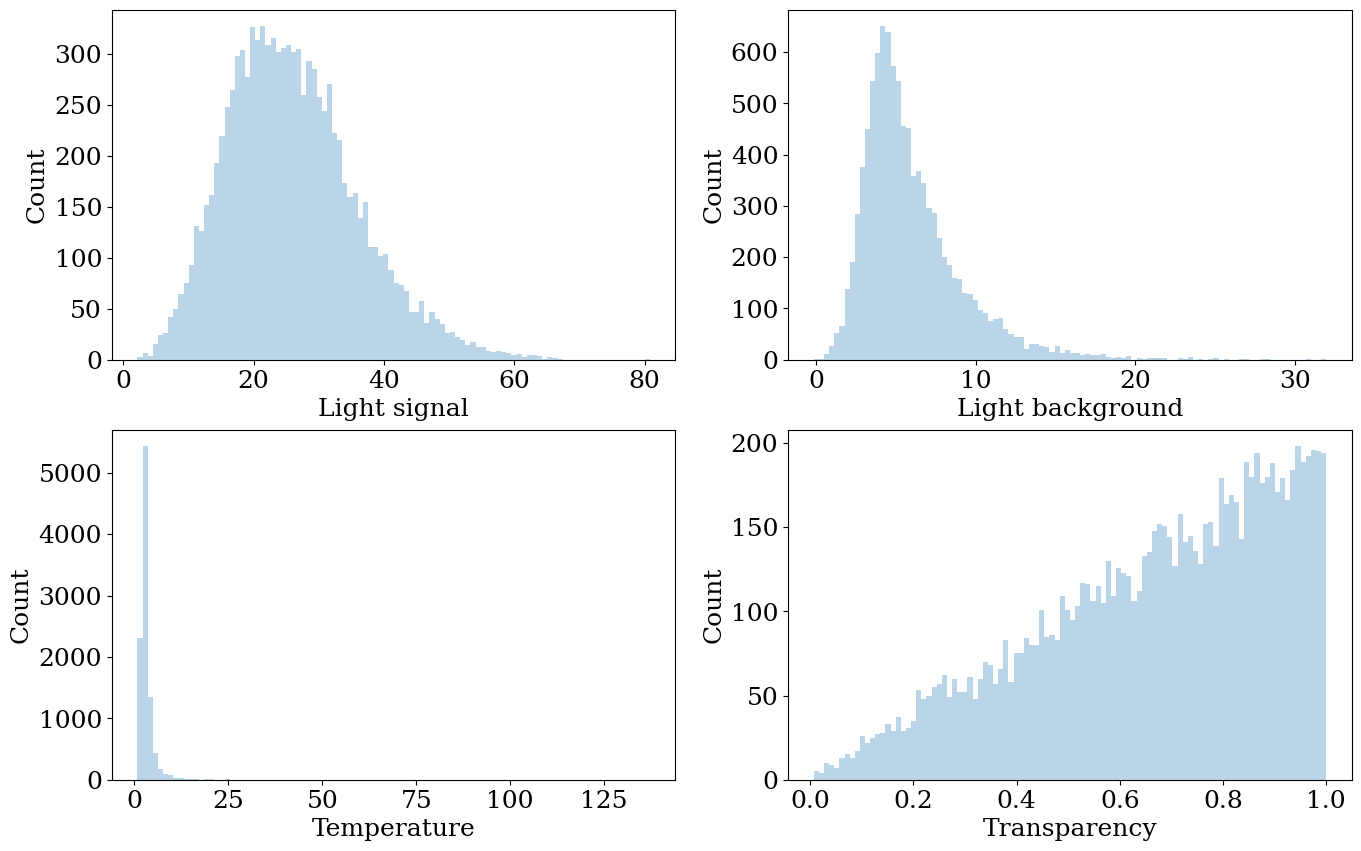

In [554]:
fig0, ax0 = plt.subplots(nrows = 2, ncols = 2, figsize = (16,10))
ax0 = ax0.flatten()

names = ['Light signal', 'Light background', 'Temperature', 'Transparency']
data_list = [lsig, lbkg, temp, tsky]



for i, data in enumerate(data_list):
    ax0[i].hist(data, bins = 100, histtype = 'stepfilled', alpha = 0.3)
    ax0[i].set(xlabel = f'{names[i]}', ylabel = 'Count')

plt.show()

In [555]:
# The initial relative resolution:

distrel = (dmeas - dknown) / dknown
print(distrel.mean())


0.4433906854849712


In [556]:
# Determine the resolution (quantified as the RMS) before and after the calibration:
distrel = (dmeas - dknown) / dknown
print(distrel.mean())
xmin, xmax = -2.0, 2.0
distrel_calibrations = np.loadtxt('distrel_calib.txt')[1:]

mask_distrel       = (xmin < distrel) & (distrel < xmax)
print("  The initial and final resolution is:  {:6.3f} \n".format(
                distrel[mask_distrel].std(ddof=1)))
for i, distrel_calib in enumerate(distrel_calibrations):
        mask_distrel_calib = (xmin < distrel_calib) & (distrel_calib < xmax)
        print(f'The resolution for calb. {i}: ',  " {:6.3f} \n".format(
              distrel_calib[mask_distrel_calib].std(ddof=1)))

0.4433906854849712
  The initial and final resolution is:   0.269 

The resolution for calb. 0:    0.035 

The resolution for calb. 1:    0.064 

The resolution for calb. 2:    0.226 

The resolution for calb. 3:    0.269 



## Compare the raw and calibrated data on a plot

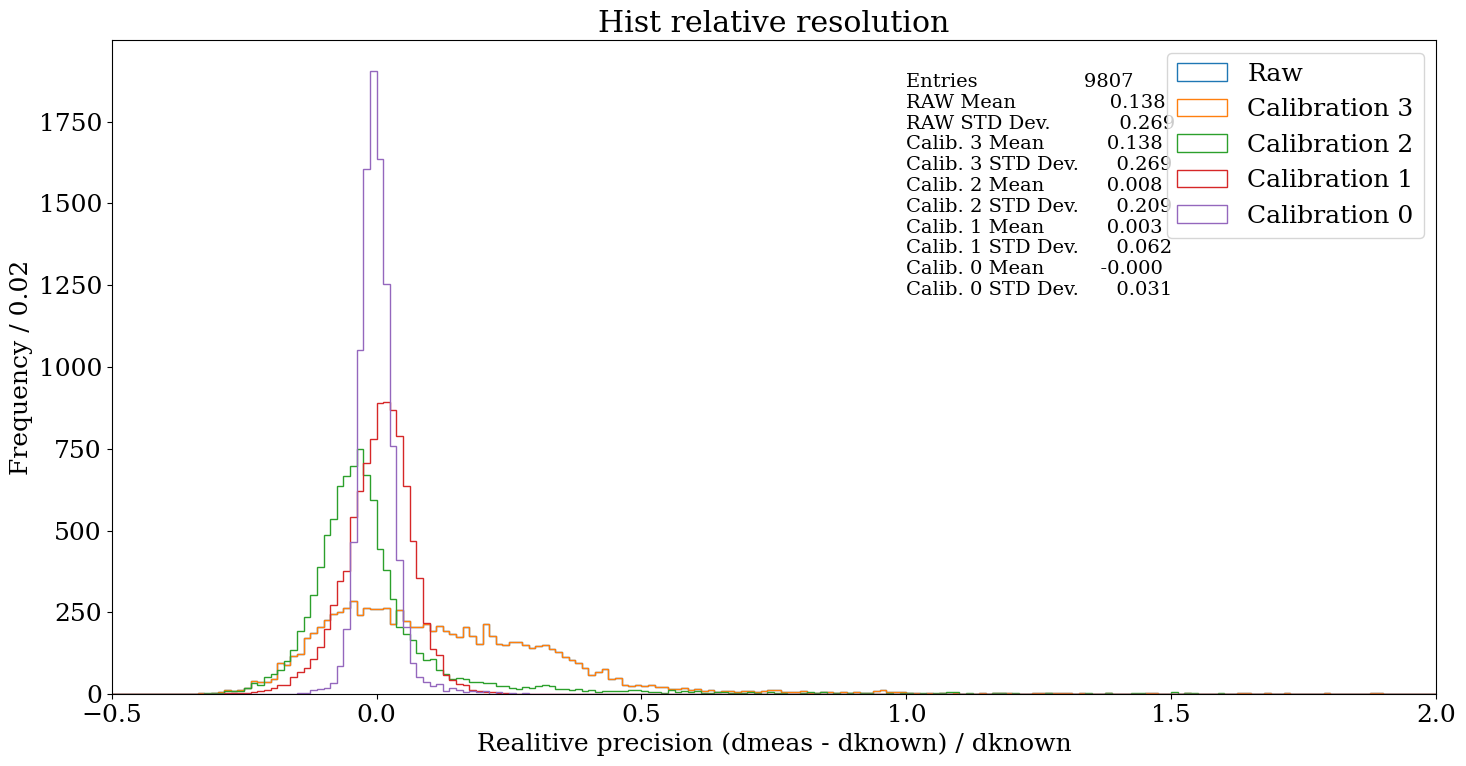

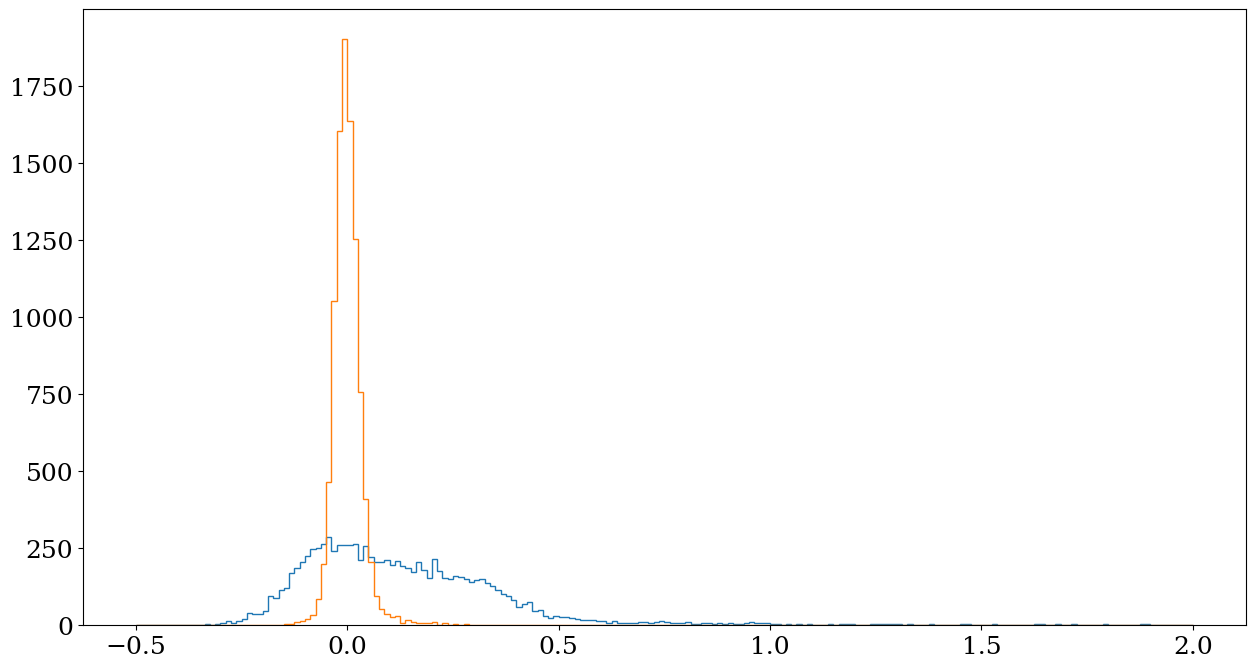

In [563]:
plt.ioff() # We use to hide the empty plot on this cell
fig_rel, ax_rel = plt.subplots(figsize=(15, 8));
ax_rel.set_title('Hist relative resolution');
Nbins = 200
xmin, xmax = -0.5, 2.0
binwidth = (xmax-xmin) / Nbins

calibrations = np.loadtxt('distrel_calib.txt')[1:]

ax_rel.hist(distrel, bins=Nbins, range=(xmin, xmax), histtype='step', label='Raw')

# Plotting attributes
ax_rel.set_xlim(xmin, xmax)
ax_rel.set_xlabel('Realitive precision (dmeas - dknown) / dknown',fontsize=18)
ax_rel.set_ylabel('Frequency / 0.02', fontsize=18)


d = {'Entries':"{:d}".format(len(distrel[mask_distrel])), 
     'RAW Mean':"{:.3f}".format(distrel[mask_distrel].mean()), 
     'RAW STD Dev.':"{:.3f}".format(distrel[mask_distrel].std(ddof=1))}

for i, calibration in reversed(list(enumerate(calibrations))):
     hist_rel_calib = ax_rel.hist(calibration, bins=Nbins, range=(xmin, xmax), histtype='step', label=f'Calibration {i}')
     mask_distrel = (xmin < distrel_calib) & (distrel_calib < xmax)
     d0 = {f'Calib. {i} Mean':"{:.3f}".format(calibration[mask_distrel].mean()), 
     f'Calib. {i} STD Dev.':"{:.3f}".format(calibration[mask_distrel].std(ddof=1))}
     d.update(d0)

ax_rel.legend(loc='best', fontsize=18)
ax_rel.text(0.6, 0.95, nice_string_output(d), family='serif', fontsize=14, 
        transform=ax_rel.transAxes, verticalalignment='top')
fig_rel.tight_layout()
plt.ion()
fig_rel

fig0, ax0 = plt.subplots(figsize = (15,8))
ax0.hist(distrel, bins=Nbins, range=(xmin, xmax), histtype='step', label=f'Raw');
ax0.hist(calibrations[0], bins=Nbins, range=(xmin, xmax), histtype='step', label=f'Fully calibrated');


In [558]:
if (SaveFigures):
    fig_rel.savefig('UncalibratedCalibrated.pdf', dpi=600)

##  Calibration using 2D histograms:

The way to investigate, if there is a (cor)relation between the target (relative distance) and any of the factors/variables/auxiliary observables, is to plot them against each other. If there are any visible relation, then this is an effect of the ourside factors (lsig, lbkg, temp, and tsky) on the wanted observable (relative distance), which we want to correct for.

In the following, we produce this 2D histogram along with a 1D graph on top showing the mean and uncertainty for each bin in x. This graph shows any possible (average) relation in a way, which can be easily fitted.

Parameters for fit 0:
Fit value: p0 = 0.14263 +/- 0.00701
Fit value: p1 = -0.00029 +/- 0.00024
chi2, pval =  51.8418641660303 0.08178171381812777
Parameters for fit 1:
Fit value: a = 0.00023 +/- 0.00015
Fit value: b = -0.02354 +/- 0.00268
Fit value: c = 0.26462 +/- 0.00996
chi2, pval =  66.58827960303435 0.025135144754586464
Parameters for fit 2:
Fit value: a = 0.03438 +/- 0.00049
Fit value: b = -0.12885 +/- 0.00457
Fit value: c = 0.16822 +/- 0.00886
chi2, pval =  58.596988576704135 0.0006133922892131692
Parameters for fit 3:
Fit value: a = 0.86721 +/- 0.03096
Fit value: b = -0.42927 +/- 0.03642
Fit value: c = -0.01722 +/- 0.00978
chi2, pval =  112.19295126132278 2.9797354948862236e-07


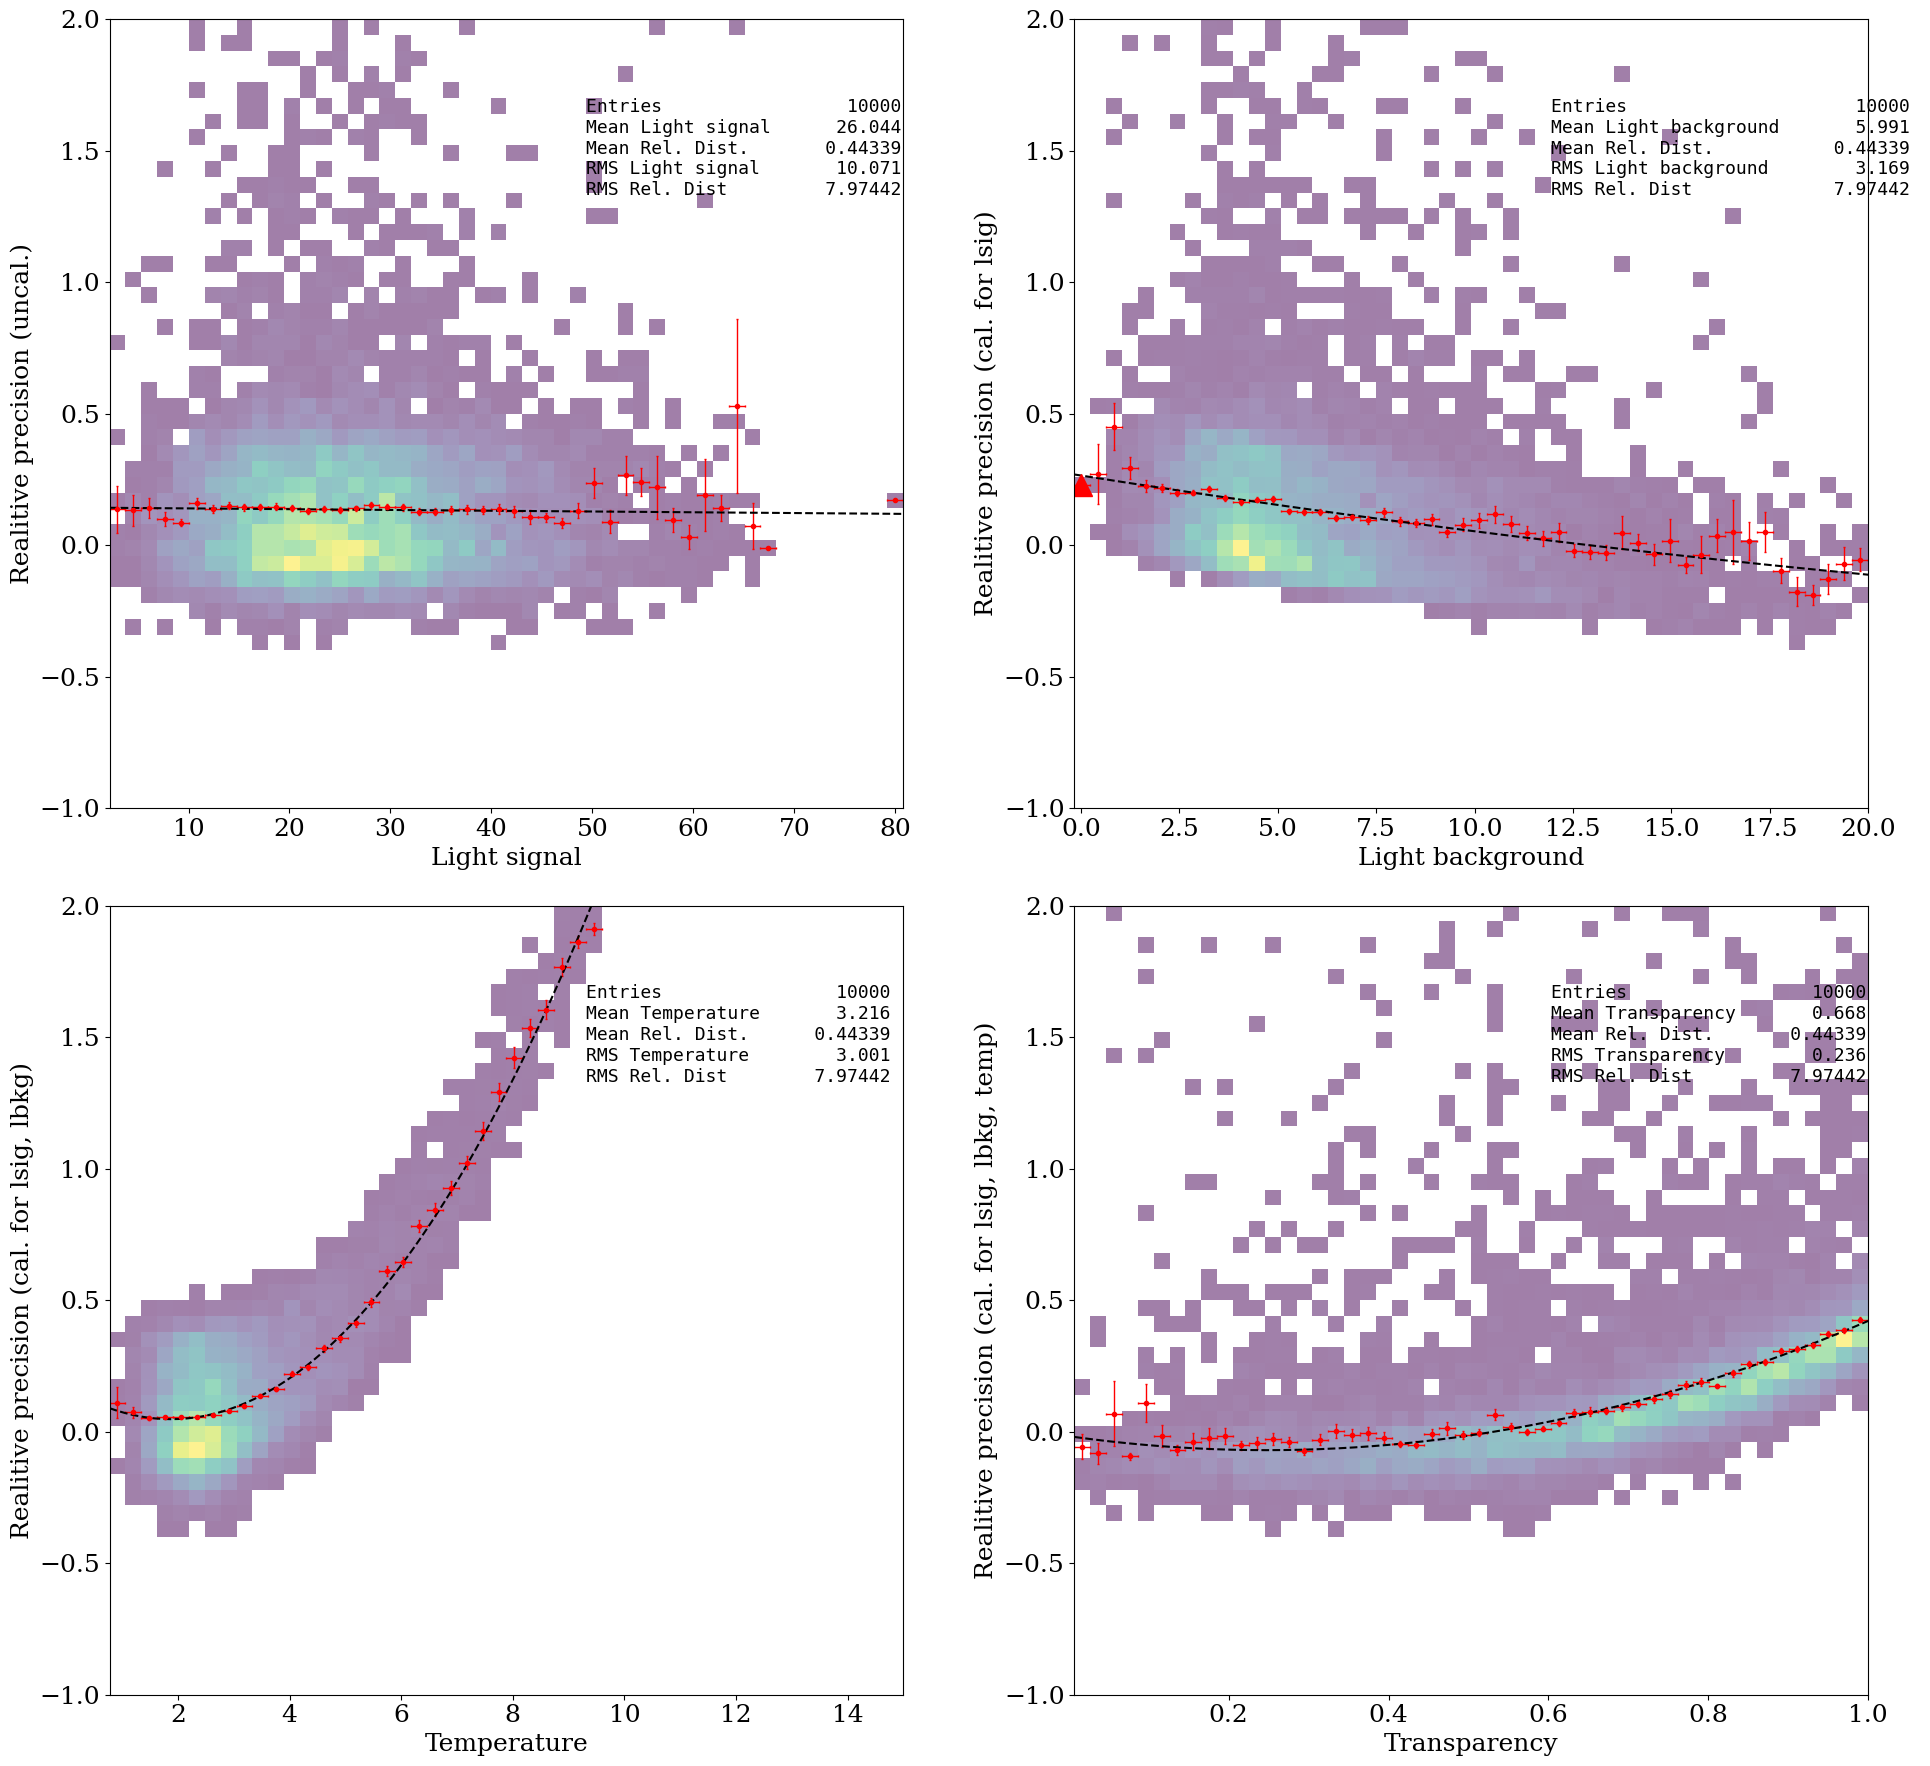

In [559]:
# Histograms for making calibration:
## define fit functions
# Fit of the effect from "lsig" in the 1D graph:
def lin_fit(x, p0, p1):
    return p0 + p1*x

def parabolic_fit(x, a, b, c):
    return a * x ** 2 + b * x + c

def logistic_fit(x, x0, y0, M, b):
    if x < 0.7:
        return y0
    else:
        return y0 + M / (1 + 1 * np.exp(- b * (x - x0)))


fig2, ax2 = plt.subplots(ncols = 2, nrows = 2, figsize = (20,18))
ax2 = ax2.flatten()


data_range = [(lsig.min(),lsig.max()), (lbkg.min(),20), (temp.min(), 15), (tsky.min(), tsky.max())]
max_no_of_fitting_parameters = 5
N_calibrations = 4
N_variables = len(data_list)
fit_parameters = np.zeros([N_variables, max_no_of_fitting_parameters])
fit_parameters_err = np.zeros_like(fit_parameters)
distrel_calib_list = [distrel] * (N_variables + 1)


ylabels = ['Realitive precision (uncal.)', 'Realitive precision (cal. for lsig)', 'Realitive precision (cal. for lsig, lbkg)', \
    'Realitive precision (cal. for lsig, lbkg, temp)']
fit_func_list = [lin_fit, parabolic_fit, parabolic_fit, parabolic_fit]
param_guesses = [np.array([0.1,0.1]), np.array([0.05,0.1,0.25]), np.array([-0.05,-0.05,-0.05]), np.array([0.005, 0, 0])]


for i, (data, fit_func) in enumerate(zip(data_list, fit_func_list)):

    range = [data_range[i],(-1, 2)]
    ax2[i].hist2d(data, distrel_calib_list[i], bins=50, range = range, cmin = 1, alpha = 0.5)
    ax2[i].set_xlabel(f'{names[i]}');
    ax2[i].set_ylabel(f'{ylabels[i]}');

        # This calculates the 1D "profile" of the 2D histogram:
    x_center, mean, std = profile_x(data, distrel_calib_list[i], bins=(50, 50), xyrange=range)
    x_binwidth = x_center[1] - x_center[0]
    mask = (std > 0)

    ax2[i].errorbar(x_center, mean, xerr=x_binwidth/2, yerr=std,  fmt='r.', 
                ecolor='r', elinewidth=1, capsize=1, capthick=1);



    chi2_object_simple = Chi2Regression(fit_func, x_center[mask], mean[mask], std[mask])

    minuit_simple = Minuit(chi2_object_simple, *param_guesses[i])
    minuit_simple.errordef = 1.0
    minuit_simple.migrad();   
    
    fit_parameters[i,0:len(minuit_simple.values)] = minuit_simple.values
    fit_parameters_err[i,0:len(minuit_simple.values)] = minuit_simple.errors


    print(f"Parameters for fit {i}:")
    for name in minuit_simple.parameters:
        print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_simple.values[name], minuit_simple.errors[name]))
    print("chi2, pval = ", minuit_simple.fval, stats.chi2.sf(minuit_simple.fval, len(std[mask]) - len(minuit_simple.values)))

    x_fit = np.linspace(data.min(), data.max(), 1000)
    fit_vec = np.vectorize(lambda x:fit_func(x, *minuit_simple.values[:]))
    #fit_vec = np.vectorize(fit_func)
    if i < 4:
        y_fit_simple = fit_vec(x_fit)
        ax2[i].plot(x_fit, y_fit_simple, '--k')
    no_std_points = std[~mask]
    ax2[i].plot(no_std_points, mean[~mask], 'r^', markersize = 16)


    ## Calibrate data:
  

    d = {'Entries':"{:d}".format(len(lsig)), \
        f'Mean {names[i]}':"{:.3f}".format(data.mean()), \
        'Mean Rel. Dist.':"{:.5f}".format(distrel_calib_list[i].mean()),
                f'RMS {names[i]}':"{:.3f}".format(data.std(ddof=1)),
                'RMS Rel. Dist':"{:.5f}".format(distrel_calib_list[i].std(ddof=1))}

    ax2[i].text(0.6, 0.9, nice_string_output(d), family='monospace', transform=ax2[i].transAxes, fontsize=13, verticalalignment='top')



fig2.tight_layout()


3
Parameters for fit 3:
Fit value: a = 0.86721 +/- 0.03096
Fit value: b = -0.42927 +/- 0.03642
Fit value: c = -0.01722 +/- 0.00978
chi2, pval =  112.19295126132278 2.9797354948862236e-07
2
Parameters for fit 2:
Fit value: a = 0.03126 +/- 0.00034
Fit value: b = -0.12222 +/- 0.00240
Fit value: c = 0.04659 +/- 0.00399
chi2, pval =  77.62944660836986 4.1882299555319155e-14
1
Parameters for fit 1:
Fit value: a = 0.00050 +/- 0.00002
Fit value: b = -0.02544 +/- 0.00042
Fit value: c = 0.13252 +/- 0.00153
chi2, pval =  121.9389865473618 3.008830868633293e-09
0
Parameters for fit 0:
Fit value: p0 = 0.00098 +/- 0.00101
Fit value: p1 = -0.00003 +/- 0.00003
chi2, pval =  34.320499265055425 0.6830712736984331
0.2775474681173848
0.4433906854849712


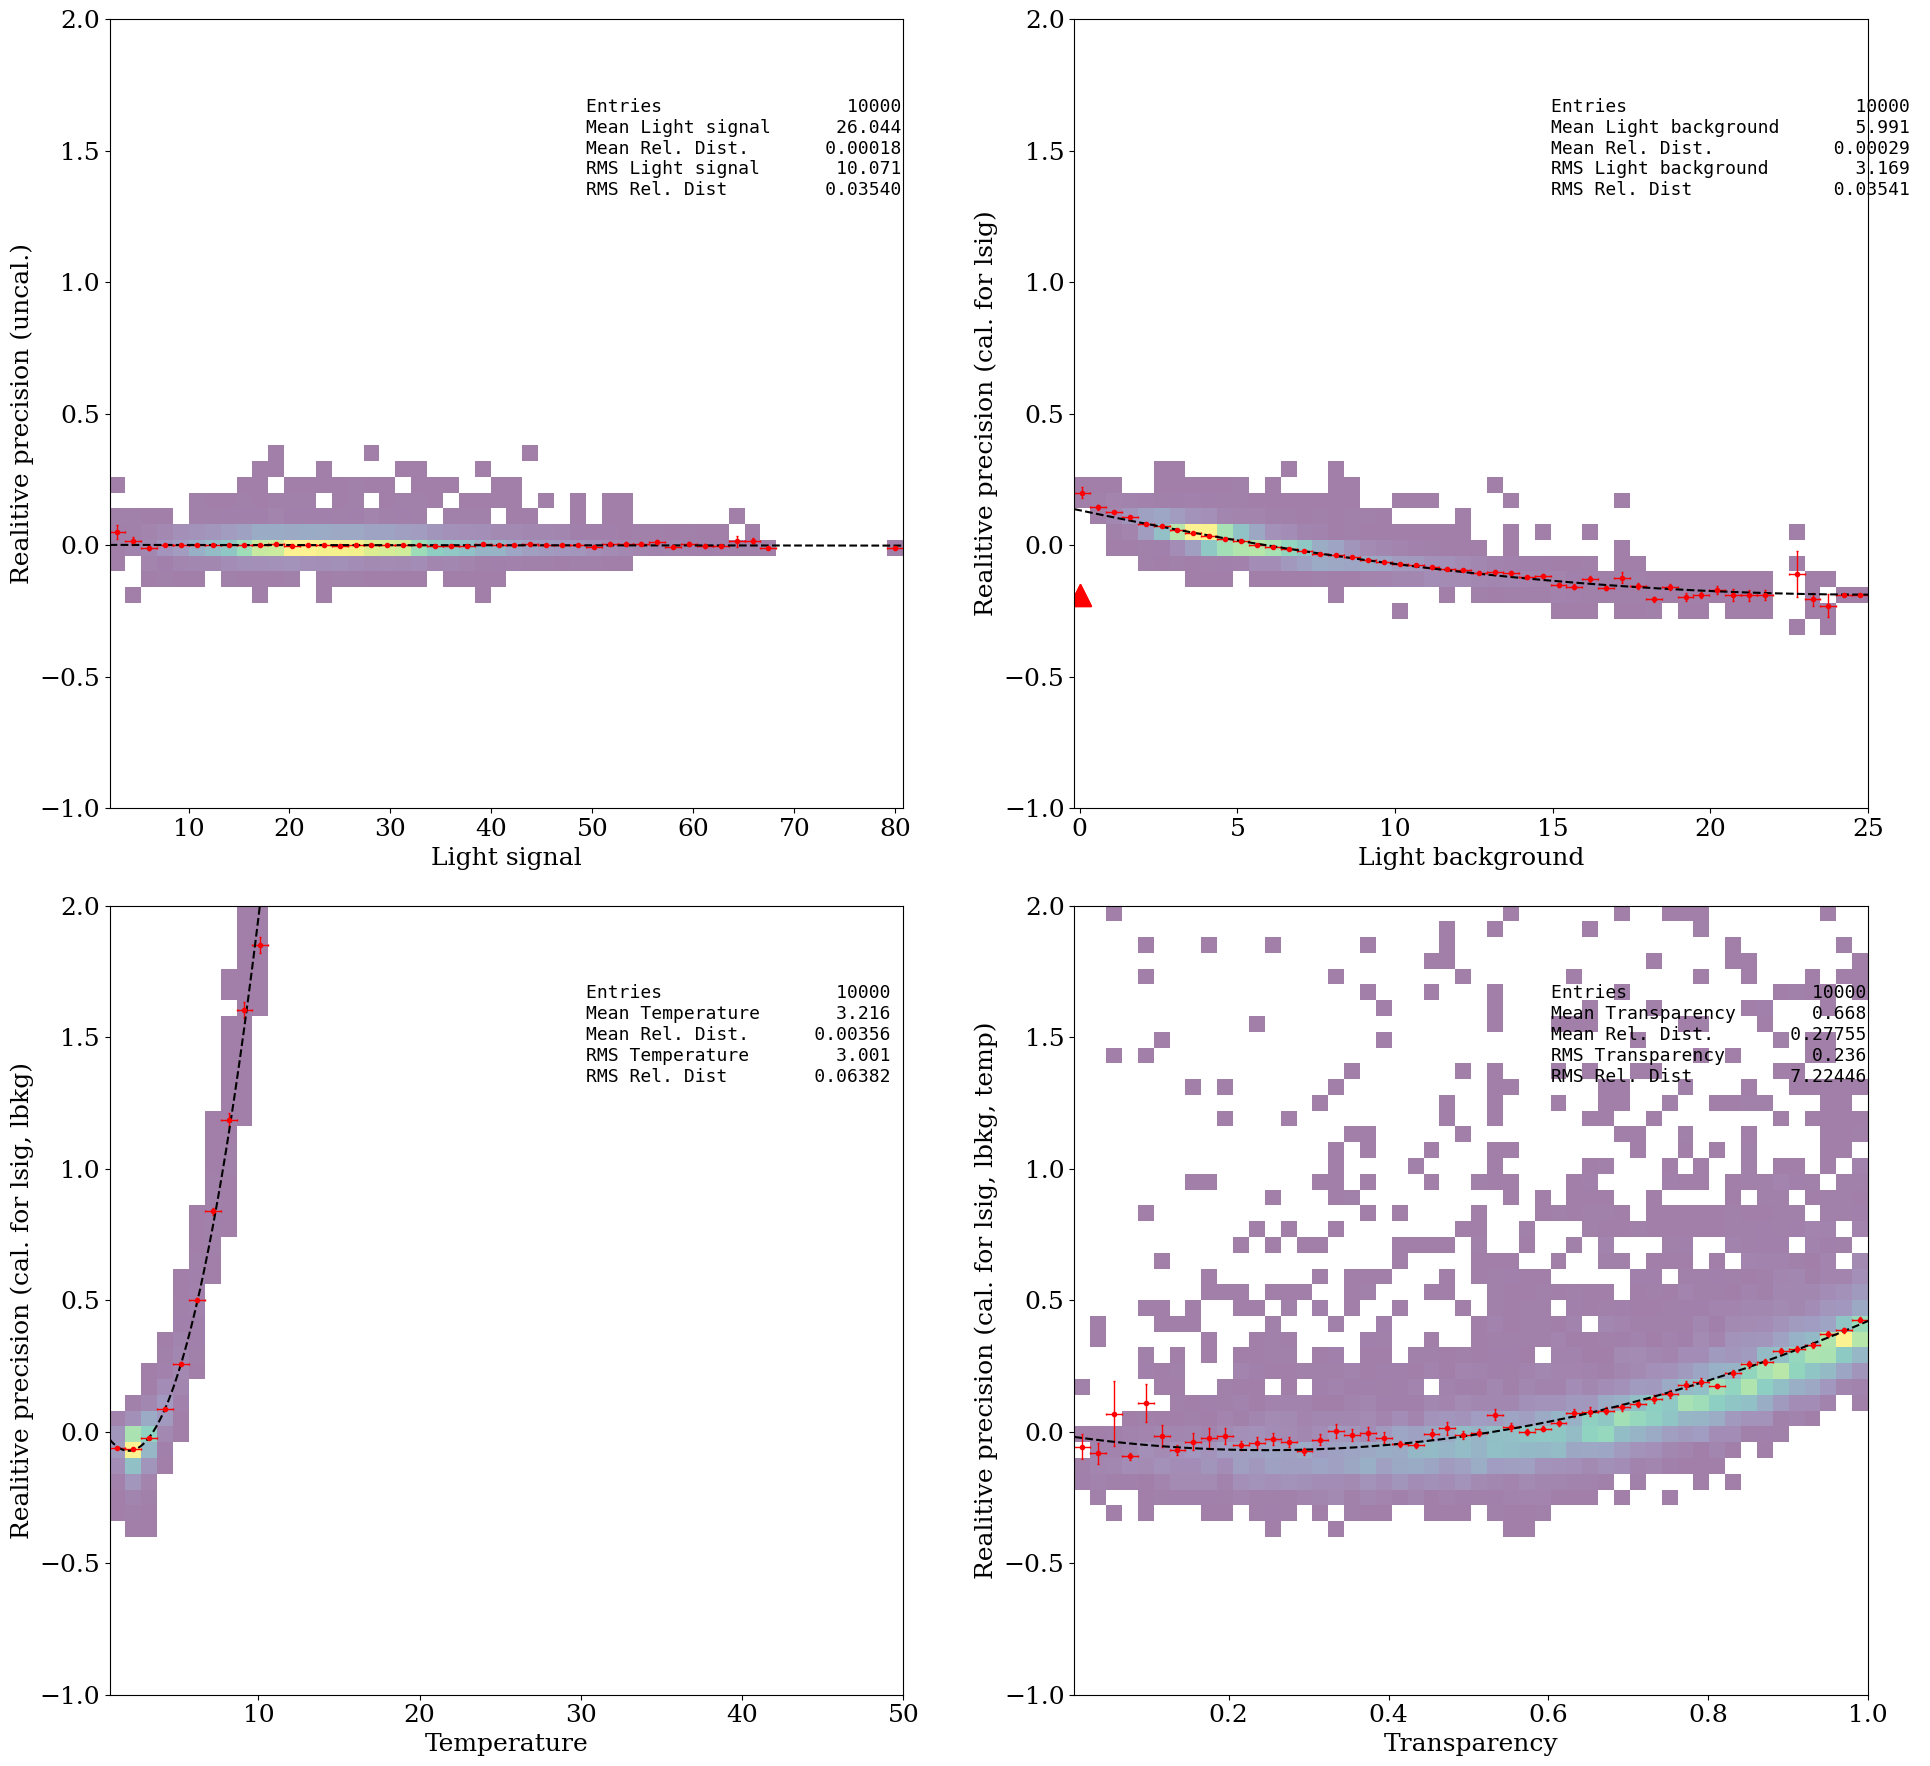

In [560]:
# Histograms for making calibration:
## define fit functions
# Fit of the effect from "lsig" in the 1D graph:
def lin_fit(x, p0, p1):
    return p0 + p1*x

def parabolic_fit(x, a, b, c):
    return a * x ** 2 + b * x + c

def logistic_fit(x, x0, y0, M, b):
    if x < 0.7:
        return y0
    else:
        return y0 + M / (1 + 1 * np.exp(- b * (x - x0)))


fig2, ax2 = plt.subplots(ncols = 2, nrows = 2, figsize = (20,18))
ax2 = ax2.flatten()


data_range = [(lsig.min(),lsig.max()), (lbkg.min(),25), (temp.min(), 50), (tsky.min(), tsky.max())]
max_no_of_fitting_parameters = 5
N_calibrations = 4
N_variables = len(data_list)
fit_parameters = np.zeros([N_variables, max_no_of_fitting_parameters])
fit_parameters_err = np.zeros_like(fit_parameters)
distrel_calib_list = [None] * (N_variables + 1)
dmeas_calib_list = [None] * (N_variables + 1)
dmeas_calib_list[-1] = dmeas
distrel_calib_list[-1] = distrel
ylabels = ['Realitive precision (uncal.)', 'Realitive precision (cal. for lsig)', 'Realitive precision (cal. for lsig, lbkg)', \
    'Realitive precision (cal. for lsig, lbkg, temp)']
fit_func_list = [lin_fit, parabolic_fit, parabolic_fit, parabolic_fit]
param_guesses = [np.array([0.1,0.1]), np.array([0.1,0.1,0.1]), np.array([-0.05,-0.05,-0.05]), np.array([0.005, 0,0])]


for i, (data, fit_func) in reversed(list(enumerate(zip(data_list, fit_func_list)))):
    print(i)
    range = [data_range[i],(-1, 2)]
    ax2[i].hist2d(data, distrel_calib_list[i+1], bins=50, range = range, cmin = 1, alpha = 0.5)
    ax2[i].set_xlabel(f'{names[i]}');
    ax2[i].set_ylabel(f'{ylabels[i]}');

        # This calculates the 1D "profile" of the 2D histogram:
    x_center, mean, std = profile_x(data, distrel_calib_list[i+1], bins=(50, 50), xyrange=range)
    x_binwidth = x_center[1] - x_center[0]
    mask = (std > 0)

    ax2[i].errorbar(x_center, mean, xerr=x_binwidth/2, yerr=std,  fmt='r.', 
                ecolor='r', elinewidth=1, capsize=1, capthick=1);



    chi2_object_simple = Chi2Regression(fit_func, x_center[mask], mean[mask], std[mask])

    minuit_simple = Minuit(chi2_object_simple, *param_guesses[i])
    minuit_simple.errordef = 1.0
    minuit_simple.migrad();   
    
    fit_parameters[i,0:len(minuit_simple.values)] = minuit_simple.values
    fit_parameters_err[i,0:len(minuit_simple.values)] = minuit_simple.errors


    print(f"Parameters for fit {i}:")
    for name in minuit_simple.parameters:
        print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_simple.values[name], minuit_simple.errors[name]))
    print("chi2, pval = ", minuit_simple.fval, stats.chi2.sf(minuit_simple.fval, len(std[mask]) - len(minuit_simple.values)))

    x_fit = np.linspace(data.min(), data.max(), 1000)
    fit_vec = np.vectorize(lambda x:fit_func(x, *minuit_simple.values[:]))
    #fit_vec = np.vectorize(fit_func)
    if i < 4:
        y_fit_simple = fit_vec(x_fit)
        ax2[i].plot(x_fit, y_fit_simple, '--k')
    no_std_points = std[~mask]
    ax2[i].plot(no_std_points, mean[~mask], 'r^', markersize = 16)


    ## Calibrate data:
    dmeas_calib_list[i] = dmeas_calib_list[i+1] / (1 + fit_vec(data))
    distrel_calib_list[i] = (dmeas_calib_list[i] - dknown) / dknown


    d = {'Entries':"{:d}".format(len(lsig)), \
        f'Mean {names[i]}':"{:.3f}".format(data.mean()), \
        'Mean Rel. Dist.':"{:.5f}".format(distrel_calib_list[i].mean()),
                f'RMS {names[i]}':"{:.3f}".format(data.std(ddof=1)),
                'RMS Rel. Dist':"{:.5f}".format(distrel_calib_list[i].std(ddof=1))}

    ax2[i].text(0.6, 0.9, nice_string_output(d), family='monospace', transform=ax2[i].transAxes, fontsize=13, verticalalignment='top')


print(distrel_calib_list[-2].mean())
print(distrel_calib_list[-1].mean())

fig2.tight_layout()

#save parameters and errors
np.savetxt('params_err.txt', fit_parameters_err)
np.savetxt('params.txt', fit_parameters)
np.savetxt('dmeas_calib.txt', dmeas_calib_list)
np.savetxt('distrel_calib.txt', distrel_calib_list)





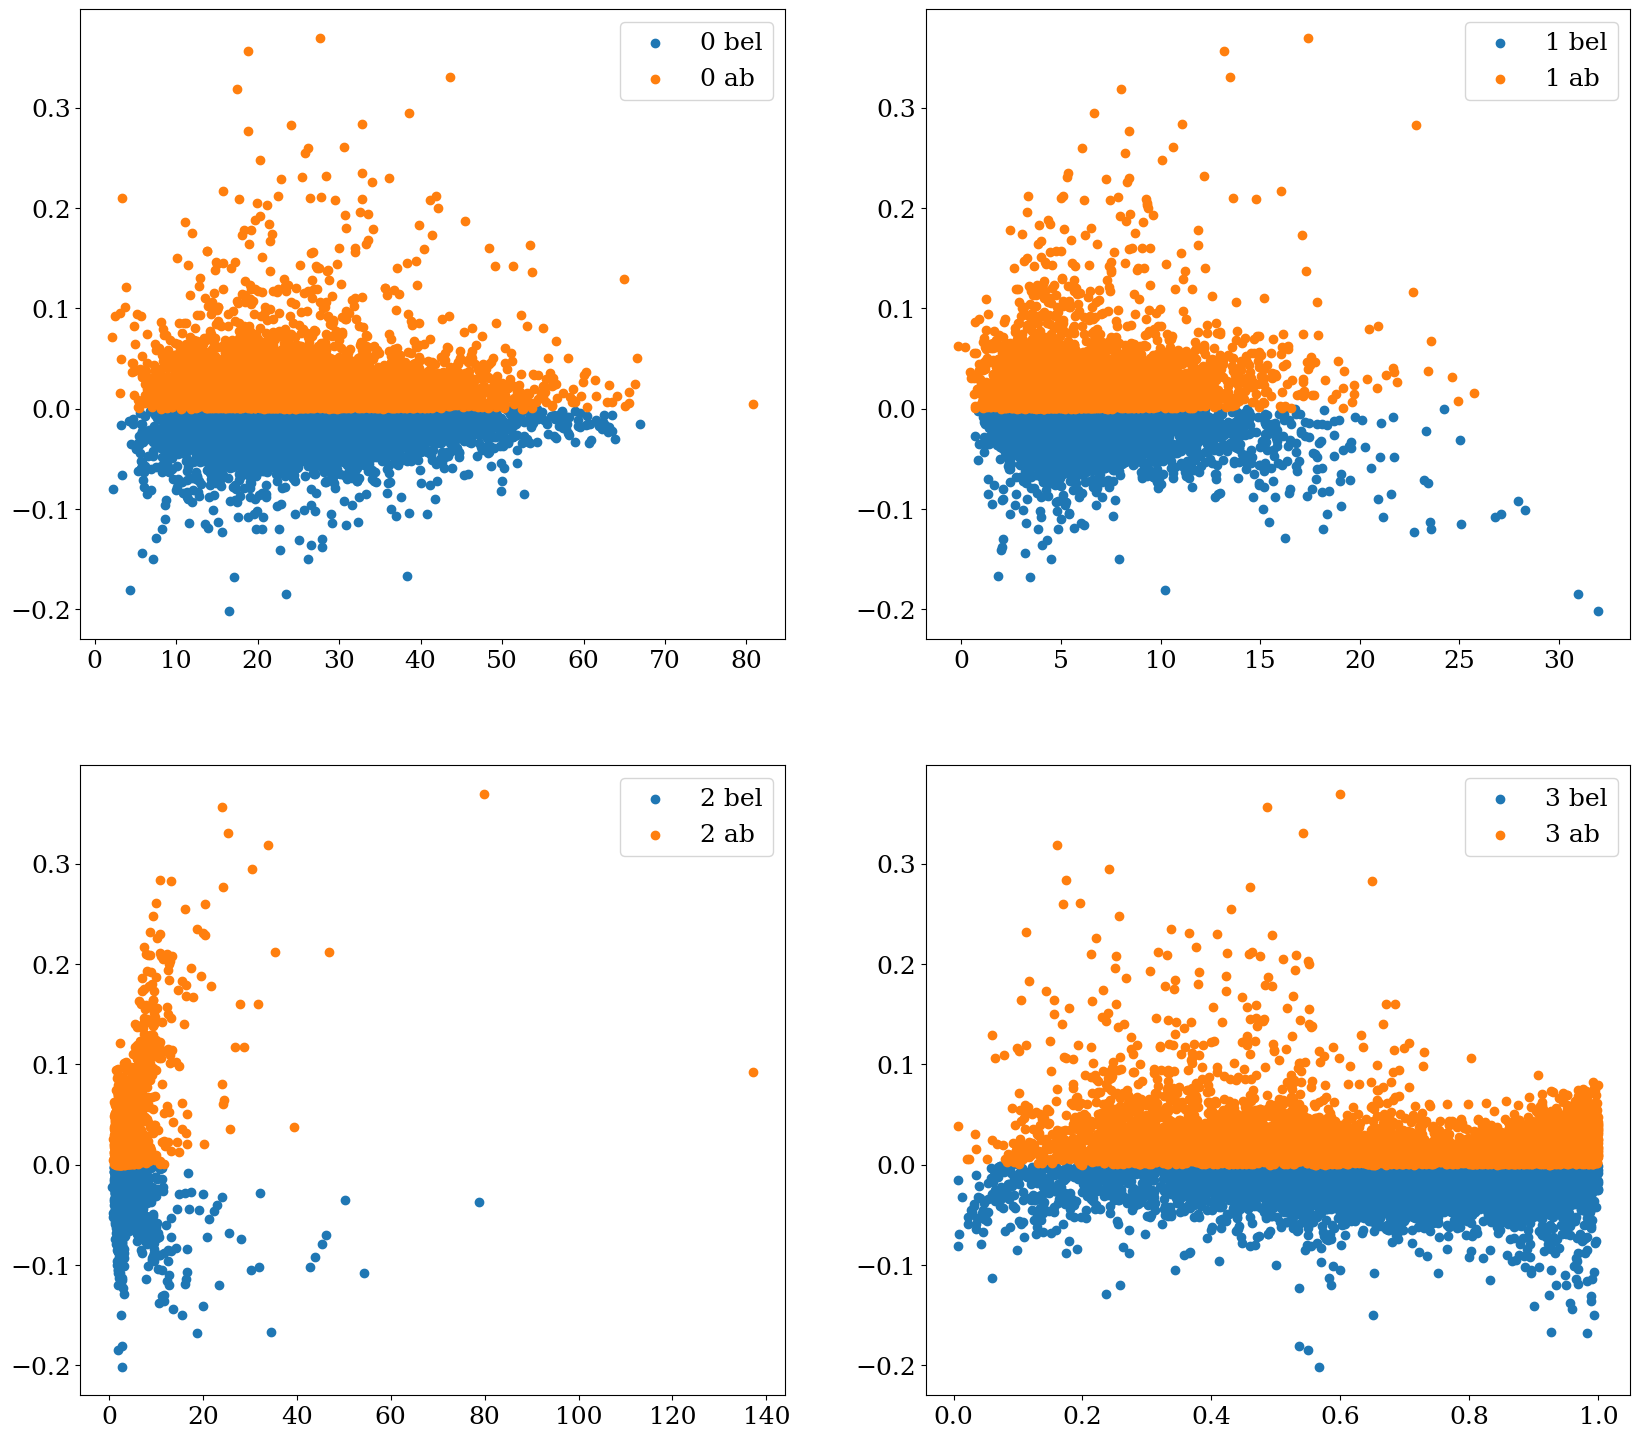

In [562]:
fig3, ax3 = plt.subplots(nrows = 2, ncols = 2, figsize = (20,18))
ax3 = ax3.flatten()
fully_calib = distrel_calib_list[0]
for i, distrel in enumerate(distrel_calib_list[1:]):
    range = [data_range[i],(-1, 25)]
    mask = (fully_calib < 0)
    ax3[i].scatter(data_list[i][mask], fully_calib[mask], label = f'{i} bel',)
    ax3[i].scatter(data_list[i][~mask], fully_calib[~mask], label = f'{i} ab',)
    ax3[i].legend()


## Your Task (reminder)

 As always look at the data and get a feel for each of the variables. A good idea might
 be to plot them all to know what range to expect them in.

 Next, consider the distribution of "relative differences" (RD) between the observed
 and actual distance: RD = (dist_obs - dist_known) / dist_known
 
 The Standard Deviation is 0.27, i.e. a 27% precision, and it is neither centered at zero
 (as it should, not to be biased), nor very Gaussian. There is also a long tail towards very
 high values. **This is what you want to improve upon!**

 Finally, there is the distribution of the bias and relative precision as a function of
 the signal luminosity (lsig). As you can see, the response does not depend on lsig,
 and so there seems to be no (varying) bias from this variable. Check the other three
 variables, and if you find some bias, try to correct for it best you can, such that you
 get the relative difference to be the most narrow Gaussian centered around 0.

 Note that if you are on average say 50% too high compared to the true values, then
 you need to correct by 50%, i.e. divide by (1 + 0.5), and in general, if your
 measurement is f(x) off, where f(x) describes the offset, then you need to divide
 by (1 + f(T)). Why:

   RD = (d - d_true) / d_true  =>  d_calib = d / (1 + f(x))

 Thus define d_calib = d / (1 + f(x)), and continue using d_calib when considering
 other effects. In the end, your calibrated measurement can be the result of several
 consecutive corrections (note that the order might matter!).
 
 Also note, that even if the function you find for correcting isn't perfect, it is probably
 still better, than doing nothing, and so it should be applied anyhow.


Questions:
----------
1. What corrections do you apply for each of the variables, and how much do each of them improve on the result?

2. What is the final resolution you obtain?

3. Do you think that further improvements are possible in this example (constructed by me)? How about in real and more complicated data?

Advanced Questions:
-------------------
4. Try at the end to figure out, which variables the final resolution depends on.
     Can you give an estimate of the uncertainty for each single star?

# Learning points:

From this exercise you should
1. Generally, understand the concept of calibration<br>
   (i.e. correcting your data for effects that you can measure/determine by some mean).
2. Be able to apply a calibration to data<br>
   (i.e. measure/determine the size of an effect, and correct data accordingly).
3. Have an idea of what to think of **ahead** of an experiment to ensure good calibration<br>
   (i.e. go through the list of needed measurements and think about how to ensure their precision).